In [42]:
import pandas as pd
import numpy as np

import sqlite3 as sql
import pprint
import time
from termcolor import colored
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import scipy.stats as st

plt.style.use('fivethirtyeight')

%matplotlib inline
pp = pprint.PrettyPrinter()

In [43]:
# getting connections to all 3 databases

database_pitch = "datasets/sqlite/pitchfork_2020.db"
conn_pitch = sql.connect(database_pitch)
c_pitch = conn_pitch.cursor()

database_meta = "datasets/sqlite/metacritic_2020.db"
conn_meta = sql.connect(database_meta)
c_meta = conn_meta.cursor()

database_needle = "datasets/sqlite/needledrop_2020.db"
conn_needle = sql.connect(database_needle)
c_needle = conn_needle.cursor() # defines the cursor

## Overview

I scraped the web for all the album reviews on pitchfork and metacritic dating back to their beginnings in 1999.

I also scraped wikipedia to get a big chunk of information on the artists' genders in said reviews. While this method is not perfect and still leaves quite a lot of unknowns (as well as potentially a very small set of wrongly assigned genders), it still gives us enough data to draw statistically significant conclusions

Before we dive into the analysis, let's have a quick look the two datasets:

## Metacritic

In [44]:
query = """
SELECT 
        r.*,
        a.categories,
        a.gender
FROM reviews r
INNER JOIN artists a ON r.artist == a.artist
"""
meta= pd.read_sql_query(query, conn_meta)

meta["metascore"] = meta["metascore"].astype(int) / 10
#meta = meta[meta["userscore"] != "tbd"]
#meta["userscore"] = meta["userscore"].astype(float)
#meta["date"] = pd.to_datetime(meta["date"], format='%B %d, %Y')


meta_sample = meta.sample(10, random_state=1)

In [45]:
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn

def save_df_as_image_meta(df, path):
    source = ColumnDataSource(df)
    df_columns = [*df.columns.values]
    #df_columns.extend(df.columns.values)
    columns_for_table=[]
    for i, column in enumerate(df_columns):
        if column in ["userscore", "metascore"]:
            columns_for_table.append(TableColumn(field=column,width=70, title=column))
        elif column == "year":
            columns_for_table.append(TableColumn(field=column,width=50, title=column))
        elif column in ["album", "artist"]:
            columns_for_table.append(TableColumn(field=column,width=120, title=column))
        elif column == "date":
            columns_for_table.append(TableColumn(field=column,width=100, title=column))
        else:
            columns_for_table.append(TableColumn(field=column,width=len(column)*10, title=column))
            
    data_table = DataTable(source=source, columns=columns_for_table,min_width=1000, width_policy="fit", max_height=300, height_policy="fit",index_position=None)
    export_png(data_table, filename = path)
    
#save_df_as_image_meta(meta_sample, "figures/metasample.png")

The Metacritic dataset contains the following columns
- album name
- artist name
- release date
- metascore - the aggregated critics score from different websites
- userscore - the metacritic userscore given as "tbd" if no users have rated the album yet
- a link to the album covers
- a short album summary
- the release year (derived from the date)
- the artist's wikipedia categories if found
- the artist's gender derived by a method of going through the wikipedia page explained on github

## Pitchfork

In [46]:
query = """
SELECT 
        r.*,
        a.categories,
        a.gender artist_gender,
        au.gender author_gender
FROM reviews r
INNER JOIN artists a ON r.artist == a.artist
INNER JOIN author au ON r.author == au.author
"""
pitchfork = pd.read_sql_query(query, conn_pitch)
pitch_sample = pitchfork.sample(10, random_state=1)

In [47]:
def save_df_as_image_pitch(df, path):
    source = ColumnDataSource(df)
    df_columns = [*df.columns.values]
    columns_for_table=[]
    for i, column in enumerate(df_columns):
        if column == "score":
            columns_for_table.append(TableColumn(field=column,width=70, title=column))
        elif column == "year":
            columns_for_table.append(TableColumn(field=column,width=50, title=column))
        elif column in ["album", "artist"]:
            columns_for_table.append(TableColumn(field=column,width=120, title=column))
        elif column in ["release_year", "review-year"]:
            columns_for_table.append(TableColumn(field=column,width=70, title=column))
        elif column in ["artist_gender", "author_gender"]:
            columns_for_table.append(TableColumn(field=column,width=80, title=column))
        elif column == "date":
            columns_for_table.append(TableColumn(field=column,width=100, title=column))
        else:
            columns_for_table.append(TableColumn(field=column,width=len(column)*10, title=column))
            
    data_table = DataTable(source=source, columns=columns_for_table,min_width=1400, width_policy="fit", max_height=300, height_policy="fit",index_position=None)
    export_png(data_table, filename = path)
    
#save_df_as_image_pitch(pitch_sample, "figures/pitchsample.png")

The Pitchfork dataset contains the following columns
- album name
- artist name
- review score
- author name
- author function at pitchfork
- the album genres according to pitchfork
- the review date
- the entire review content
- the url to the review
- special labels such as "Best New Music" or "Best New Reissue"
- the review year
- the artist's wikipedia categories if found
- the artist's gender derived by a method of going through the wikipedia page explained on github
- the author's gender - manually selected by googling the author. "unknown When unsure about prefered gender. In case of disagreement please contact me

In [48]:
df = pitchfork.merge(meta, on=["album", "artist"])
df.sample(5, random_state=1)

,album,artist,score,author,author_type,genre,review_date,label,release_year,content,...,artist_gender,author_gender,date,metascore,userscore,cover,summary,year,categories_y,gender
2305,Feels Like,Bully,7.8,Laura Snapes,Contributor,Rock,2015-06-25 06:00:01,Columbia,2015,"The coarse Cobain head-scream of Bully singer,...",...,unknown,female,"June 23, 2015",7.7,8.3,https://static.metacritic.com/images/products/...,The debut full-length release for the Nashvill...,2015,"['All articles with unsourced statements', 'Al...",unknown
6409,Anniemal,Annie,8.8,Scott Plagenhoef,Contributor,"Electronic, Pop/R&B",2004-11-07 06:00:01,679,2004,"Featuring production from Richard X, R?yksopp'...",...,female,male,"June 7, 2005",8.1,8.6,https://static.metacritic.com/images/products/...,This debut full-length by the Norwegian singer...,2005,"['1977 births', '20th-century Norwegian singer...",female
1686,The Healing Component,Mick Jenkins,7.6,Dean Van Nguyen,Contributor,Rap,2016-09-28 05:00:00,Cinematic,2016,The Chicago rapper’s debut LP is a daring and ...,...,male,male,"September 23, 2016",7.9,7.5,https://static.metacritic.com/images/products/...,The debut full-length studio release for the C...,2016,"['1991 births', '21st-century American male mu...",male
4711,All Day,Girl Talk,8.3,Ian Cohen,Contributor,Electronic,2010-11-29 06:00:00,Illegal Art,2010,Gregg Gillis continues to do what he does bett...,...,male,male,"November 15, 2010",7.9,8.3,https://static.metacritic.com/images/products/...,Gregg Gillis releases his latest album of mash...,2010,"['1981 births', 'American DJs', 'American bioe...",male
4200,Talk That Talk,Rihanna,6.0,Lindsay Zoladz,Contributor,Pop/R&B,2011-11-23 06:00:00,Def Jam,2011,Heavy on filler even though it's only 11 track...,...,female,female,"November 21, 2011",6.4,7.0,https://static.metacritic.com/images/products/...,The Barbados-born singer's sixth studio album ...,2011,"['1988 births', '21st-century singers', '21st-...",female


In [49]:
from scipy.stats import pearsonr

r_value, p_value = pearsonr(userscores, metascores)
print("r value between userscore and metascore:",  r_value)
r_value, p_value = pearsonr(pitchscores, metascores)
print("r value between pitchscore and metascore:",  r_value)
r_value, p_value = pearsonr(pitchscores, userscores)
print("r value between pitchscore and userscores:",  r_value)

r value between userscore and metascore: 0.41822814375649225
r value between pitchscore and metascore: 0.6909229445282516
r value between pitchscore and userscores: 0.31918766858302494


Now that we have a sense of the given data let's draw some graphs and maybe find some interesting trends in the history of online music reviews...

Some of the questions we are hoping to answer:
- Is music really getting worse every year?
- Is the industry gender-biased
- ...

We will start with a simple question:

## What was the best year for music?

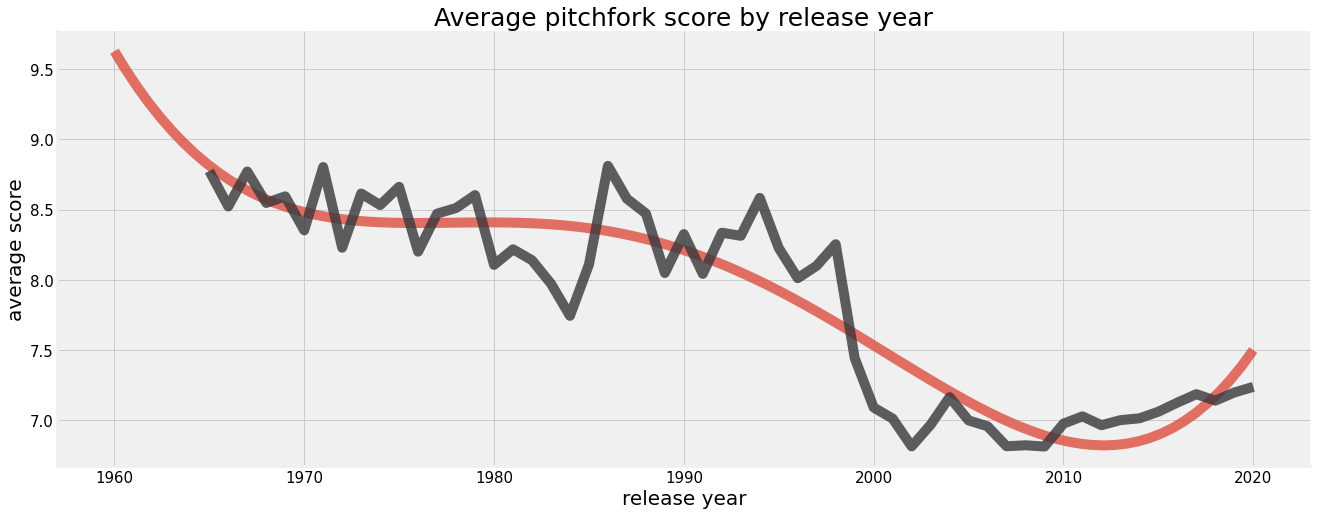

In [50]:
query = """
SELECT         
        r.release_year year,
        ROUND(AVG(r.score), 3) "average score",
        COUNT(*) "albums released that year"
FROM reviews r
INNER JOIN artists a ON r.artist == a.artist
GROUP BY r.release_year
HAVING "albums released that year" > 5 AND year != " "
"""
df= pd.read_sql_query(query, conn_pitch)

model = np.poly1d(np.polyfit(df.year, df["average score"], 4))
years = np.linspace(1960,2020,100)

fig = plt.figure(figsize=(20, 8))
plt.plot(years, model(years), alpha=0.8, linewidth=10,color="#dc4e40")
plt.plot(df.year, df["average score"], alpha=0.8, linewidth=10, color="#373739")
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Average pitchfork score by release year", size=25)
plt.ylabel("average score", size=20)
plt.xlabel("release year", size=20)
sns.despine(right=True, top=True, left=False, bottom=False)
#plt.savefig("figures/cover part 1.png")

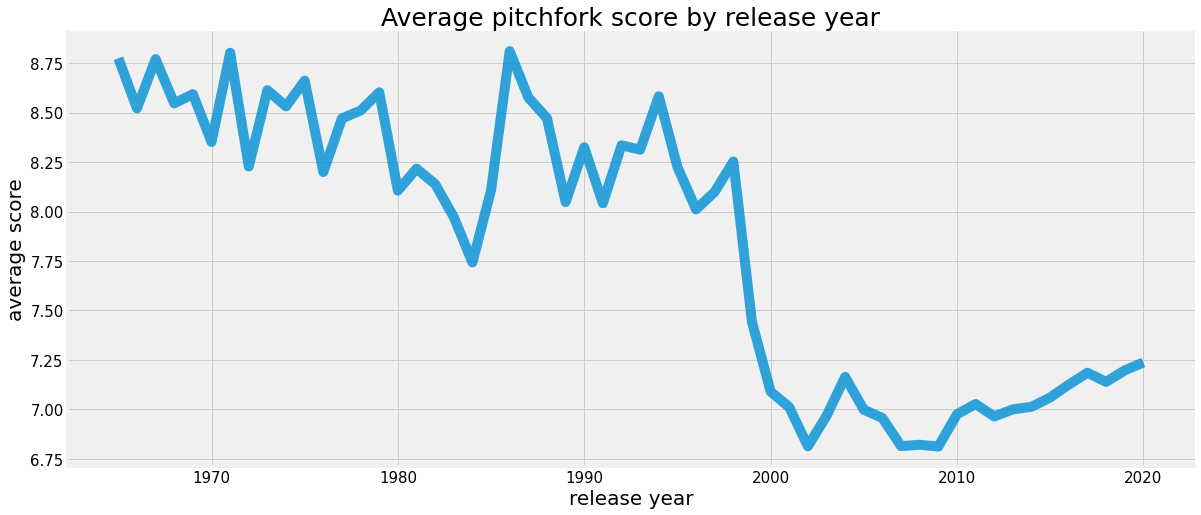

In [51]:
query = """
SELECT         
        r.release_year year,
        ROUND(AVG(r.score), 3) "average score",
        COUNT(*) "albums released that year"
FROM reviews r
INNER JOIN artists a ON r.artist == a.artist
GROUP BY r.release_year
HAVING "albums released that year" > 5 AND year != " "
"""
df= pd.read_sql_query(query, conn_pitch)

model = np.poly1d(np.polyfit(df.year, df["average score"], 4))
years = np.linspace(1960,2020,100)

fig = plt.figure(figsize=(18, 8))
#plt.plot(years, model(years), alpha=0.8, linewidth=10,color=colors[0])
plt.plot(df.year, df["average score"], alpha=0.8, linewidth=10, color=colors[0])
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Average pitchfork score by release year", size=25)
plt.ylabel("average score", size=20)
plt.xlabel("release year", size=20)
sns.despine(right=True, top=True, left=False, bottom=False)
#plt.savefig("figures/score by release year.png")

There it is: __1986!__

Who knew the answer could be this simple...
It should be no surprise to anyone that the highest average score is from a year before pitchfork started operating online. Of course nobody in the pitchfork team will spend hours listening to Eddie Murphy's "Party All The Time" just to write an extensive review about how uninspiring the instrumentals were. The disc has been forgotten and should stay forgotten with the sole exception of a booze-heavy stag do coming to an end at 4am.

On the other hand it is by no means a surprise, that at some point in their 20 year history, someone at pitchfork has decided to give us their take on The Beatles' white album and it also shouldn't come as a surprise, that it will score very highly on the list (a 10). 

However unsuprising this result is, let's visualize it:

In [52]:
pitchfork[pitchfork.release_year == " "]
pitchfork.replace(r'^\s*$', np.nan, regex=True, inplace=True)
pitchfork.release_year.fillna(pitchfork.review_year, inplace=True)
pitchfork.release_year = pitchfork.release_year.astype(int)
pitchfork["nostalgia_factor"] = pitchfork.review_year.astype(int) - pitchfork.release_year

In [53]:
## Could also do one with all the dates
nostalgia_1 = pitchfork.groupby("nostalgia_factor").mean()
nostalgia_2 = pitchfork[pitchfork.release_year >= 1999].groupby("nostalgia_factor").mean()

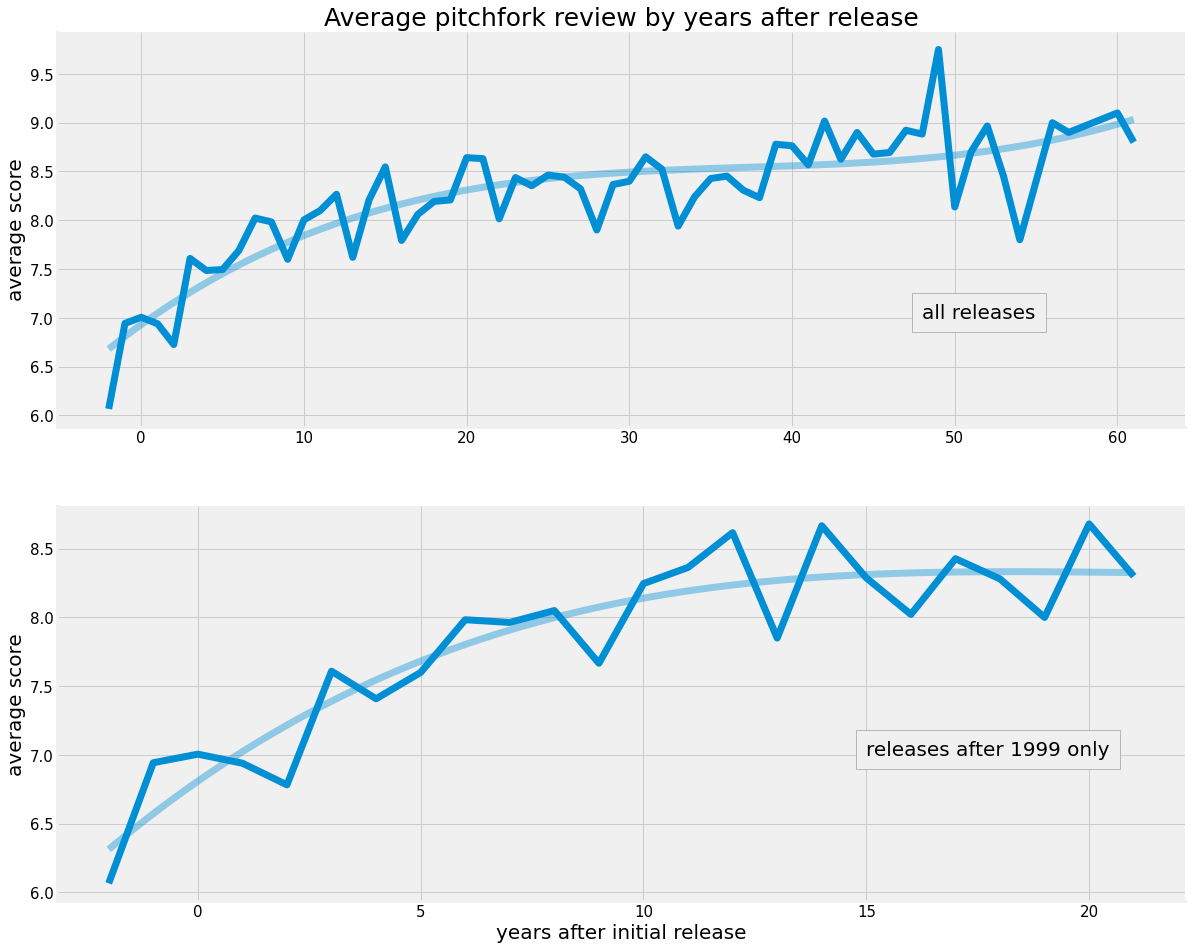

In [54]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15) 

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 16))
#fig = plt.figure(figsize=(18, 10))
axes[0].plot(nostalgia_1.index, nostalgia_1["score"],  linewidth=7)
axes[1].plot(nostalgia_2.index, nostalgia_2["score"],  linewidth=7)
axes[0].set_title("Average pitchfork review by years after release", size=25)
axes[0].set_ylabel("average score", size=20)
axes[1].set_ylabel("average score", size=20)
axes[0].text(48, 7, 'all releases', size=20, bbox=dict(facecolor='#f0f0f0', edgecolor='grey', pad=10.0))
axes[1].text(15, 7, 'releases after 1999 only', size=20, bbox=dict(facecolor='#f0f0f0', edgecolor='grey', pad=10.0))
plt.xlabel("years after initial release", size=20)
sns.despine(right=True, top=True, left=False, bottom=False)
#plt.savefig("figures/nostalgia factor.png")

model_1 = np.poly1d(np.polyfit(nostalgia_1.index, nostalgia_1["score"], 3))
model_2 = np.poly1d(np.polyfit(nostalgia_2.index, nostalgia_2["score"], 3))

years_1 = np.linspace(-2,61,100)
years_2 = np.linspace(-2,21,100)

axes[0].plot(years_1, model_1(years_1),alpha=0.4, linewidth=7, label="regression model", color=colors[0])
_=axes[1].plot(years_2, model_2(years_2),alpha=0.4, linewidth=7, label="regression model", color=colors[0])

#plt.savefig("figures/nostalgia factor with regression.png")


There is a very clear trend to be seen here: 
The longer the time between an album release and its review, the better the score is on average. Just like we suspected. This even is the case for albums released after 1999 when pitchfork was already online.

Can we thus conclude, that reviewers are biased towards older albums? Well… not quite (yet). The point we made earlier about reviewers being more likely to pick out a (subjectively) good old album to feature in their review as opposed to a bad one, remains valid. But we now have strong evidence suggesting that this theory is indeed supported by the data we are given. This also explains, why many people tend to say that the best years in music lie behind us. Our judgement is subconsciously skewed by the disproportionate amount of positive reviews we see of past albums, as well as by our own selective memory of only "the greats". This at least are two factors explaining the phenomenon.

To answer the question whether or not reviewers are really influenced by their own nostalgia, let's have a look at one more graph. We want to find out how many perfect scores (10) have been given out to albums every release year.

In [55]:
query = """
SELECT         
    *
FROM reviews 

"""
df= pd.read_sql_query(query, conn_pitch)
df[(df.score==10) & (df.release_year == " ")]

,album,artist,score,author,author_type,genre,review_date,label,release_year,content,url,special_label,review_year
22468,Animals,Pink Floyd,10.0,James P. Wisdom,nan,Rock,2000-04-25 06:00:00,Columbia,,It begins somewhere for everyone. There's the ...,https://pitchfork.com/reviews/albums/6307-anim...,nan,2000


In [56]:
df.loc[22468,"release_year"] = 1977 ## this is "animals by pink floyd"

In [57]:
df["original_release"] = df.release_year


## This was all manual work. I only did 10/10 albums
df.loc[21930,"original_release"] = 1967
df.loc[20301,"original_release"] = 1981
df.loc[18948,"original_release"] = 1979
df.loc[19642,"original_release"] = 1975
df.loc[17553,"original_release"] = 1975
df.loc[13925,"original_release"] = 1983
df.loc[12484,"original_release"] = 1997
df.loc[13009,"original_release"] = 1989
df.loc[13025,"original_release"] = 1970
df.loc[13070,"original_release"] = 2000
df.loc[13230,"original_release"] = 1984 ##2009
df.loc[9119,"original_release"] = 2006 ##2006 exception
df.loc[11649,"original_release"] = 1996
df.loc[12129,"original_release"] = 1989
df.loc[12204,"original_release"] = 1972
df.loc[12464,"original_release"] = 1999
df.loc[10484,"original_release"] = 1971
df.loc[10524,"original_release"] = 1991
df.loc[10614,"original_release"] = 1991
df.loc[11489,"original_release"] = 1999
df.loc[9259,"original_release"] = 2003
df.loc[5727,"original_release"] = 1964
df.loc[3770,"original_release"] = 1984
df.loc[817,"original_release"] = 1982
df.loc[880,"original_release"] = 1969
df.loc[1363,"original_release"] = 1957

In [58]:
## manually correcting release year/original release
df[(df.original_release == 2003)&(df.score==10)] 

,album,artist,score,author,author_type,genre,review_date,label,release_year,content,url,special_label,review_year,original_release
9259,The Disintegration Loops,William Basinski,10.0,Mark Richardson,Contributor,Experimental,2012-11-19 06:00:00,Temporary Residence,2012,The four volumes of William Basinski's ambient...,https://pitchfork.com/reviews/albums/17064-the...,Best new reissue,2012,2003
20302,The Ascension,Glenn Branca,10.0,Andy Beta,Contributor,"Experimental, Rock",2003-06-19 05:00:00,Acute,2003,I was teaching the Dwight highschoolers how to...,https://pitchfork.com/reviews/albums/909-the-a...,nan,2003,2003


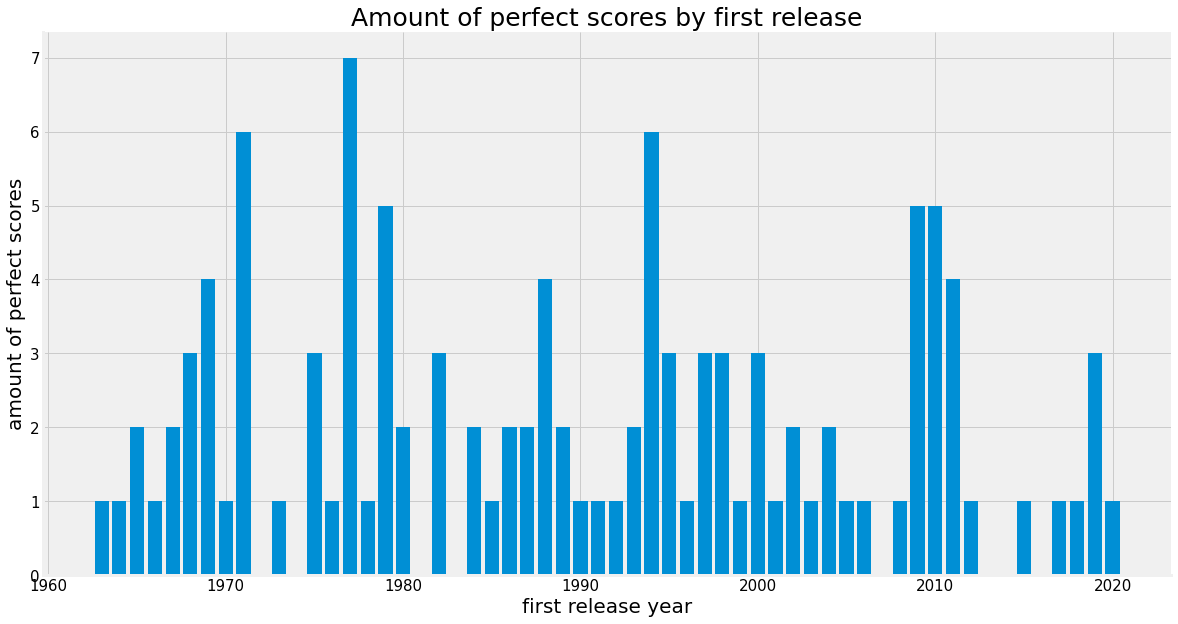

In [59]:
counter = df[df.score==10].groupby("release_year").count().artist.reset_index()
counter.columns=["release_year", "10_star_albums"]
fig = plt.figure(figsize=(18, 10))
plt.bar(counter.release_year, counter["10_star_albums"],  linewidth=5)
#plt.bar(counter.release_year, counter["10_star_albums"],  linewidth=5)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Amount of perfect scores by first release", size=25)
plt.ylabel("amount of perfect scores", size=20)
plt.xlabel("first release year", size=20)
sns.despine(right=True, top=True, left=False, bottom=False)
#plt.savefig("figures/perfect scores by release year.png")

A few stats:

- Out of the ten years with the most amount "perfect albums", seven years are from before 1999, while only three years are from after 1999, when pitchfork started reviewing online. 
- The 70s have a total of 25 perfect albums, the 2010s only had 16
- On average a year from before 1999 has 2.44 perfect albums whereas a year from after 1999 only has 1.94
- According to this measure 1977 was the best year for music

However, upon closer inspection we can see that many of the albums are actually compilations or re-releases of much older works. When we sort by the original release date, the graph is even more skewed!

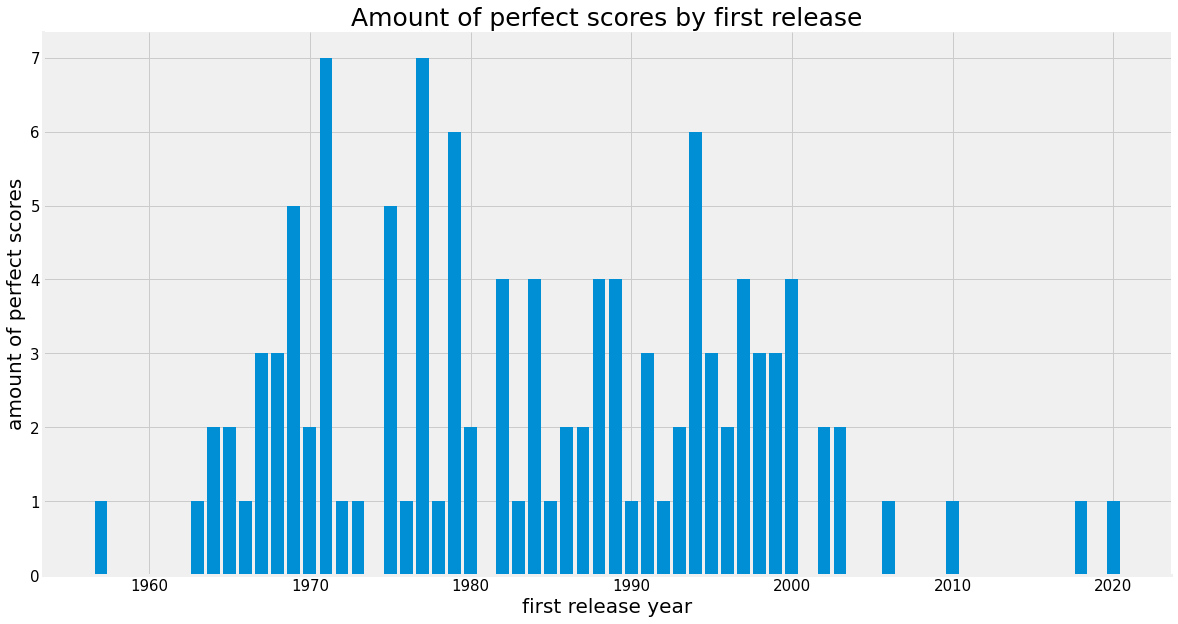

In [60]:
counter = df[df.score==10].groupby("original_release").count().artist.reset_index()

counter.columns=["release_year", "10_star_albums"]
fig = plt.figure(figsize=(18, 10))
plt.bar(counter.release_year, counter["10_star_albums"],  linewidth=5)
#plt.bar(counter.release_year, counter["10_star_albums"],  linewidth=5)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Amount of perfect scores by first release", size=25)
plt.ylabel("amount of perfect scores", size=20)
plt.xlabel("first release year", size=20)
sns.despine(right=True, top=True, left=False, bottom=False)
#plt.savefig("figures/perfect scores per year original.png")

A few updated stats:
- Out of the 7 albums that got perfect scores in the years 1999 and 2000 only 1 (Kid A) actually got the score that same year. 4 of the others got reviewed over a decade later and the 7th album is just a reissue of "Kid A".
- One of the perfect scores in 2003 also got its score 10 years later
- In total there have only been 9 albums since 1999 that got perfect scores in the year of their release
- The 70s now have 31 perfect albums and the 2010s only have 2
- On average a year from before 1999 has 2.8 perfect albums whereas a year from after 1999 only has about 0.75
- According to this measure 1977 and 1971 are the best years for music

Wikipedia tells us that in total, including some years in the 1990s  we don't have data for, only 12 albums got a perfect score upon initial release:

In [61]:
counter["decade"] = 0
counter["decade"][(counter.release_year >= 1950) & (counter.release_year < 1960)] = 1950
counter["decade"][(counter.release_year >= 1960) & (counter.release_year < 1970)] = 1960
counter["decade"][(counter.release_year >= 1970) & (counter.release_year < 1980)] = 1970
counter["decade"][(counter.release_year >= 1980) & (counter.release_year < 1990)] = 1980
counter["decade"][(counter.release_year >= 1990) & (counter.release_year < 2000)] = 1990
counter["decade"][(counter.release_year >= 2000) & (counter.release_year < 2010)] = 2000
counter["decade"][(counter.release_year >= 2010) & (counter.release_year < 2020)] = 2010
counter["decade"][(counter.release_year >= 2020) & (counter.release_year < 2030)] = 2020
#nineties

In [62]:
counter.groupby("decade").sum()["10_star_albums"]

decade
1950     1
1960    17
1970    31
1980    24
1990    28
2000     9
2010     2
2020     1
Name: 10_star_albums, dtype: int64

Another way to visualize the disparity is by plotting the average amount of 10 star albums before 1999 and after 1999

In [72]:
pre_mean = counter[counter.release_year < 1999]["10_star_albums"].mean()
post_mean = counter[counter.release_year >= 1999]["10_star_albums"].mean()

In [73]:
print("pre 1999:",pre_mean,"\n\npost 1999:",post_mean)

pre 1999: 2.8 

post 1999: 1.875


This method should silence the last doubters that claimed the top 10 list was skewed because oviously there have been more years before 1999 than there have been after 1999.

Here it is blue on grey: The nostalgia factor is indeed real. Even without the last few graphs however, we should ask ourselves the question: Was music really better in the old times? 

It might often seem that way and there sure has been a lot of pre 1990s music released that we still listen to at weddings, bars, graduation parties or even in some cases in nightclubs. But every generation has had their Nickelback (cheap shot I know). We just don't talk about them. But maybe that's a good thing

In [74]:
query = """
SELECT        
    artist,
    AVG(score) average,
    COUNT(score) counter
FROM reviews 
GROUP BY artist
HAVING counter > 4
ORDER BY average

"""
df= pd.read_sql_query(query, conn_pitch)
df

,artist,average,counter
0,The Dandy Warhols,3.620000,5
1,Joan of Arc,3.700000,7
2,The Get Up Kids,4.266667,6
3,Gomez,4.360000,5
4,The Mars Volta,4.457143,7
...,...,...,...
950,Talking Heads,9.025000,8
951,Fleetwood Mac,9.080000,5
952,Fiona Apple,9.100000,6
953,John Coltrane,9.100000,5


## What are the worst albums of all time?

In [75]:
query = """
SELECT 
        MIN(r.score) minimum_score,
        r.release_year year,
        COUNT(*) "amount of albums"
FROM reviews r
INNER JOIN artists a ON r.artist == a.artist
GROUP BY r.release_year
HAVING "amount of albums" > 10 AND year != " "
"""
df= pd.read_sql_query(query, conn_pitch)
df.head()

,minimum_score,year,amount of albums
0,7.5,1967,14
1,6.2,1968,17
2,6.2,1969,17
3,5.8,1970,25
4,7.0,1971,35


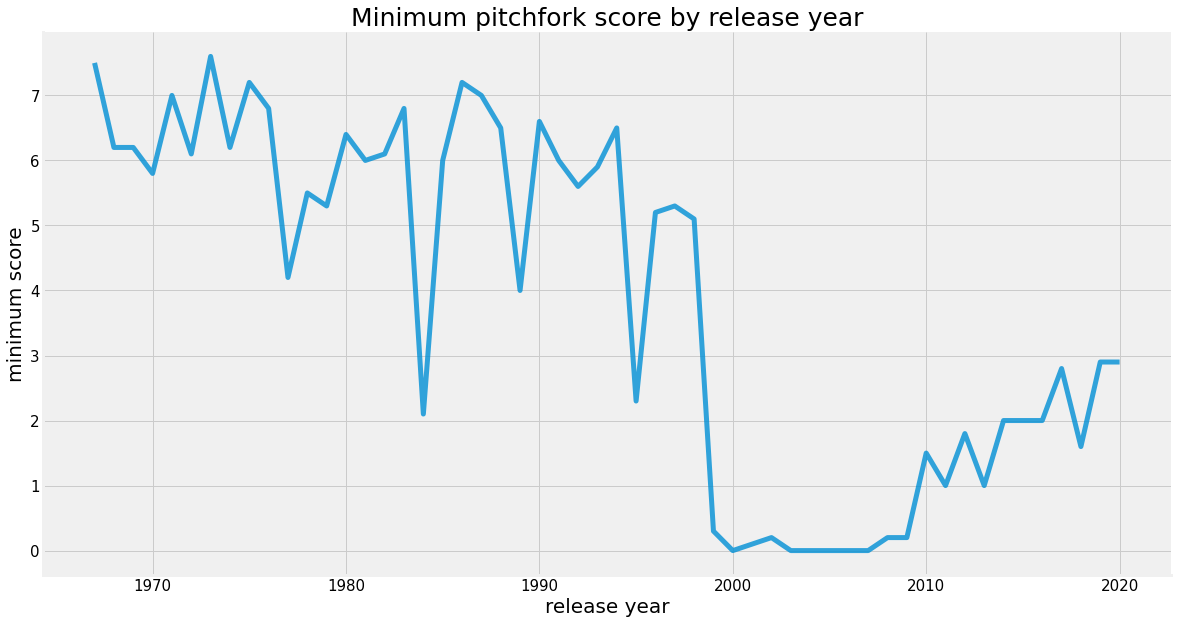

In [76]:
fig = plt.figure(figsize=(18, 10))
plt.plot(df.year, df.minimum_score, alpha=0.8, linewidth=5)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Minimum pitchfork score by release year", size=25)
plt.ylabel("minimum score", size=20)
plt.xlabel("release year", size=20)
sns.despine(right=True, top=True, left=False, bottom=False)
#plt.savefig("figures/worst scores pitchfork.png")

Looks like we have a few zeros in the noughties. Let's see what they are

In [77]:
query = """
SELECT 
        *
FROM reviews r
INNER JOIN artists a ON r.artist == a.artist
WHERE r.score == 0
"""
df= pd.read_sql_query(query, conn_pitch)
df.head(10)

,album,artist,score,author,author_type,genre,review_date,label,release_year,content,url,special_label,review_year,artist,categories,gender
0,This Is Next,Various Artists,0.0,Matt LeMay,Contributor,nan,2007-08-22 06:00:01,Vice,2007,Basically an ADA sampler with a promotional st...,https://pitchfork.com/reviews/albums/10571-thi...,nan,2007,Various Artists,"['Album types', 'All articles containing poten...",unknown
1,Shine On,Jet,0.0,Ray Suzuki,Contributor,Rock,2006-10-02 06:00:05,Elektra,2006,nan,https://pitchfork.com/reviews/albums/9464-shin...,nan,2006,Jet,"['2001 establishments in Australia', '2012 dis...",unknown
2,Relaxation of the Asshole,Robert Pollard,0.0,Eric Carr,Contributor,Rock,2005-04-20 05:00:03,Rockathon,2005,If more drunks would learn from Robert Pollard...,https://pitchfork.com/reviews/albums/6383-rela...,nan,2005,Robert Pollard,"['1957 births', 'All articles with dead extern...",male
3,Travistan,Travis Morrison,0.0,Chris Dahlen,nan,Pop/R&B,2004-09-27 06:00:01,Barsuk,2004,After a prestigious and fruitful career fronti...,https://pitchfork.com/reviews/albums/5607-trav...,nan,2004,Travis Morrison,"['1972 births', 'All BLP articles lacking sour...",male
4,Liz Phair,Liz Phair,0.0,Matt LeMay,Contributor,Rock,2003-06-24 05:00:00,Capitol,2003,It could be said that Liz Phair's greatest ass...,https://pitchfork.com/reviews/albums/6255-liz-...,nan,2003,Liz Phair,"['1967 births', '20th-century American guitari...",female
5,NYC Ghosts & Flowers,Sonic Youth,0.0,Brent DiCrescenzo,Contributor,Rock,2000-04-30 05:00:06,Geffen,2000,"No, I have not forgotten to put the numbers in...",https://pitchfork.com/reviews/albums/7342-nyc-...,nan,2000,Sonic Youth,"['1981 establishments in New York (state)', 'A...",unknown
